<a href="https://colab.research.google.com/github/ACTP2002/EVIDENCE/blob/behavior_model/Behaviour_Model_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --no-cache-dir -U numpy pandas scipy scikit-learn tensorflow shap matplotlib joblib h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 202.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 251.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 256.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 283.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 179.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 276.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 289.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 MB 212.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 249.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
  Attempting uninstall: tensorboard
    Found exis

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import median_abs_deviation
import random

import h2o
from h2o.estimators import H2OExtendedIsolationForestEstimator
from h2o.estimators import H2OPrincipalComponentAnalysisEstimator

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

import shap
import joblib


In [2]:
data_path = "synthetic_data_2026-02-07.csv"

df = pd.read_csv(data_path)
df.head()

,user_id,txn_id,event_time,event_type,amount,currency,channel,declared_income,account_deposit,residence_country,geo_country,amount_in_1d,amount_out_1d,login_count_1h,failed_login_1h,new_ip_1d,geo_change_1d
0,u_123,tx001,2025-04-29T00:41:35,deposit,4340.76,GBP,api,103233,201910,AU,AU,7383.39,7514.33,0,0,False,False
1,u_066,tx002,2025-12-12T02:40:46,withdrawal,7644.75,JPY,mobile,147944,491914,BR,BR,5619.80,13616.50,0,0,True,False
2,u_323,tx003,2025-03-03T11:31:43,sell,6430.32,USD,mobile,89130,57834,CN,CN,13932.37,3767.63,4,0,False,False
3,u_279,tx004,2025-11-24T00:26:14,buy,303.06,EUR,api,26802,421080,CN,CN,3947.08,1865.10,2,0,True,False
4,u_380,tx005,2025-04-22T23:01:29,buy,1164.22,EUR,api,25900,280156,MY,MY,1918.26,1456.34,0,0,False,False


In [3]:
# convert time to proper format
df["event_time"] = pd.to_datetime(df["event_time"], errors="coerce")
# sort by user id and event time
df = df.sort_values(["user_id", "event_time"]).reset_index(drop=True)

# Normalize categorical text to ensure all lower text
cat_cols_raw = [
    "currency", "channel",
    "residence_country", "geo_country",
    "event_type"
]

for c in cat_cols_raw:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.lower()

In [4]:
df.head()

,user_id,txn_id,event_time,event_type,amount,currency,channel,declared_income,account_deposit,residence_country,geo_country,amount_in_1d,amount_out_1d,login_count_1h,failed_login_1h,new_ip_1d,geo_change_1d
0,u_000,tx6788,2025-01-06 11:18:48,deposit,10254.28,gbp,mobile,102892,82668,vn,vn,12593.03,11280.03,0,0,False,False
1,u_000,tx11835,2025-02-03 17:39:16,withdrawal,3584.68,usd,web,102892,82668,vn,vn,11413.28,7055.52,3,1,True,False
2,u_000,tx17428,2025-02-14 13:10:20,deposit,7219.40,gbp,api,102892,82668,vn,vn,14621.12,8020.41,3,2,True,False
3,u_000,tx8036,2025-02-15 17:08:36,withdrawal,9331.13,gbp,api,102892,82668,vn,vn,9792.10,9161.38,0,0,True,False
4,u_000,tx19337,2025-02-18 00:55:12,deposit,5060.26,usd,mobile,102892,82668,vn,vn,15287.90,9269.69,1,2,False,False


Feature Engineering Process




1.   Rolling behaviour for each user. Purpose: To compare the behaviour within the n
window

User transaction rate:


*   More than 7 transactions => USER MEDIAN + USER MAD
*   Between 2 to 6 transactions => USER MEDIAN + GLOBAL MAD
*   1 Transaction => COHORT MEDIAN + MAD

2.   Transaction timing
3.   Financial Patterns
4.   Location Abnormality

In [5]:
# Transaction Amount Features

df["amount_abs"] = df["amount"].abs()

df["amount_to_income_ratio"] = (df["amount_abs"] / (df["declared_income"] + 1e-9))

df["deposit_to_income_ratio"] = (df["account_deposit"] / (df["declared_income"] + 1e-9))

# Net flow per day
df["net_flow_1d"] = df["amount_in_1d"] - df["amount_out_1d"]

# Transaction Gap features

grp = df.groupby("user_id", sort=False)

# Previous timestamp per group
df["prev_event_time"] = grp["event_time"].shift(1)

# Gap between consecutive transactions (in seconds)
df["gap_seconds"] = (df["event_time"] - df["prev_event_time"]).dt.total_seconds()

# Fill first-transaction gaps
df["gap_seconds"] = df["gap_seconds"].fillna(df["gap_seconds"].median())

# Log-scaled time gap
df["gap_log"] = np.log1p(df["gap_seconds"])


# Inconsistent Location

df["is_cross_border"] = (df["residence_country"] != df["geo_country"]).astype(int)


# Access risk
df["failed_login_ratio_1h"] = (df["failed_login_1h"] / (df["login_count_1h"] + 1e-9))

df["new_ip_1d"] = df["new_ip_1d"].fillna(0)

df["geo_change_1d"] = df["geo_change_1d"].fillna(0)



In [7]:
# 1 TRANSACTION ONLY

EPS = 1e-9

# GLOBAL MEDIAN & MAD
GLOBAL_MEDIAN = df["amount_abs"].median()
GLOBAL_MAD = median_abs_deviation(df["amount_abs"], scale="normal") + EPS

# COHORT MEDIAN + MAD
cohort_cols = ["currency", "geo_country", "channel", "event_type"]
cohort_stats = (df.groupby(cohort_cols)["amount_abs"].agg(["median", lambda x: median_abs_deviation(x, scale="normal")]).reset_index())
cohort_stats.columns = cohort_cols + ["cohort_median", "cohort_mad"]
cohort_stats["cohort_mad"] += 1e-9

df = df.merge(cohort_stats, on=cohort_cols, how="left")

In [8]:
ROLL_WINDOW = 15
ROLL_MIN = 2 # minimum transactions for rolling window else treated as single transaction

# Rolling windows (15 transactions minimum, 2 transactions at least to compute)
df["user_median_15"] = grp["amount_abs"].transform(lambda s: s.rolling(ROLL_WINDOW, min_periods=ROLL_MIN).median())

# Rolling MAD
df["user_mad_15"] = grp["amount_abs"].transform(lambda s: s.rolling(ROLL_WINDOW, min_periods=ROLL_MIN).apply(lambda x: median_abs_deviation(x, scale="normal"), raw=False))

# Fallback logic [User level => Cohort level => Global level]
df["baseline_median"] = df["user_median_15"].fillna(df["cohort_median"]).fillna(GLOBAL_MEDIAN)
df["baseline_mad"] = df["user_mad_15"].fillna(df["cohort_mad"]).fillna(GLOBAL_MAD)

# Modified z-score
df["mod_z_score"] = 0.6745 * (df["amount_abs"] - df["baseline_median"]) / (df["baseline_mad"] + EPS)
df["mod_z_score_abs"] = df["mod_z_score"].abs()

In [9]:
### EWMA (Exponentially Weighted Moving Average)
df["ewma"] = grp["amount_abs"].transform(lambda s: s.ewm(span=8, adjust=False).mean())

df["ewma_resid"] = (df["amount_abs"] - df["ewma"]).abs()


In [10]:
# Global chronological split (80,20)
cutoff = df["event_time"].quantile(0.8)

train_df = df[df["event_time"] <= cutoff].copy()
test_df = df[df["event_time"] > cutoff].copy()

print("Train:", train_df.shape, "Test:", test_df.shape)


Train: (16000, 36) Test: (4000, 36)


Extended Isolation Forest Model

Role: Detect any anomalous event or outlier

Covers:
1. Monetary Behavior: features are modified_z_score, ewma_resid, net_flow_1d
2. Temporal: features are gap_log
3. Access: features are login_count_1h, failed_login_ratio_1h, new_ip_1d
4. Geographic: is_cross_border

Features have been selected after investigating the correlation. For those highly correlated features, only one of them was maintained to improve diversity

In [11]:
# Step 1: Select the features that have high impact in determining the outlier

num_features = [
    "mod_z_score_abs",
    "ewma_resid",
    "gap_log",
    "net_flow_1d",
    "login_count_1h",
    "failed_login_ratio_1h",
    "new_ip_1d",
    "is_cross_border"
]
# isolation_forest_features = ["amount_abs", "mod_z_score_abs", "ewma_resid", "gap_log", "deposit_to_income_ratio", "amount_to_income_ratio", "amount_in_1d", "net_flow_1d", "is_cross_border"]

cat_features = [
    "currency",
    "channel",
    "event_type",
    "transaction_country"
]

# isolation_forest_features = [c for c in isolation_forest_features if c in df.columns]
num_features = [c for c in num_features if c in df.columns]
cat_features = [c for c in cat_features if c in df.columns]

In [12]:
h2o.init()

encoding = "one_hot_explicit"
eif = H2OExtendedIsolationForestEstimator(
    ntrees = 600,
    sample_size = 256,
    extension_level = len(cat_features)+len(num_features)-1,
    seed = 42,
    categorical_encoding = encoding
)

eif.train(x=cat_features+num_features, training_frame=h2o.H2OFrame(train_df))



Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.17" 2025-10-21; OpenJDK Runtime Environment (build 17.0.17+10-Ubuntu-122.04); OpenJDK 64-Bit Server VM (build 17.0.17+10-Ubuntu-122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.12/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpocr4oh5s
  JVM stdout: /tmp/tmpocr4oh5s/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpocr4oh5s/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,2 months and 19 days
H2O_cluster_name:,H2O_from_python_unknownUser_w3pakh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.168 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%


,number_of_trees,size_of_subsample,extension_level,seed,number_of_trained_trees,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves,min_isolated_point,max_isolated_point,mean_isolated_point,min_not_isolated_point,max_not_isolated_point,mean_not_isolated_point,min_zero_splits,max_zero_splits,mean_zero_splits
,600,256,10,42.0,600.0,8.0,8.0,8.0,10.0,90.0,35.981667,5.0,54.0,20.35,202.0,251.0,235.65,0.0,20.0,3.21


In [13]:
# Calculate score
eif_result = eif.predict(h2o.H2OFrame(test_df))

# Prediction score
anomaly_score = eif_result["anomaly_score"]

# Average path length  of the point in Isolation Trees from root to the leaf
mean_length = eif_result["mean_length"]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


In [14]:
# Convert the H2OFrame to a pandas DataFrame and extract the values as a Series/Array
test_df["iforest_score"] = anomaly_score.as_data_frame().iloc[:, 0].values
test_df["mean_length"] = mean_length.as_data_frame().iloc[:, 0].values

/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [15]:
print(test_df["iforest_score"])

53       0.634959
54       0.626519
55       0.599820
56       0.583904
57       0.523729
           ...   
19995    0.384172
19996    0.394716
19997    0.370912
19998    0.364150
19999    0.421905
Name: iforest_score, Length: 4000, dtype: float64


In [16]:
train_df[num_features].corr()

,mod_z_score_abs,ewma_resid,gap_log,net_flow_1d,login_count_1h,failed_login_ratio_1h,new_ip_1d,is_cross_border
mod_z_score_abs,1.000000,0.733976,0.000678,0.652475,0.011376,0.001255,0.006157,-0.005408
ewma_resid,0.733976,1.000000,-0.002803,0.749927,0.016469,-0.001917,0.001973,-0.004476
gap_log,0.000678,-0.002803,1.000000,0.003993,0.013787,0.012945,0.009866,0.004517
net_flow_1d,0.652475,0.749927,0.003993,1.000000,0.008485,-0.002888,0.001175,-0.002739
login_count_1h,0.011376,0.016469,0.013787,0.008485,1.000000,-0.132512,0.000690,0.000927
failed_login_ratio_1h,0.001255,-0.001917,0.012945,-0.002888,-0.132512,1.000000,-0.004893,0.008923
new_ip_1d,0.006157,0.001973,0.009866,0.001175,0.000690,-0.004893,1.000000,0.001396
is_cross_border,-0.005408,-0.004476,0.004517,-0.002739,0.000927,0.008923,0.001396,1.000000


LSTM AutoEncoder
- Detect unusual transaction patterns better than isolation forest
- Used for temporal anomalies

In [17]:
from sklearn.preprocessing import StandardScaler

# STEP 1: Identify features, create sequences, and create training and testing data

lstm_autoencoder_features = ["amount_abs", "gap_log", "amount_to_income_ratio", "net_flow_1d", "deposit_to_income_ratio", "mod_z_score_abs", "ewma_resid"]

seq_scaler = StandardScaler()
seq_scaler.fit(train_df[lstm_autoencoder_features].fillna(0))

def make_sequences(data_in, window=20):
  X = []
  idx = []
  for _, g in data_in.groupby("user_id", sort=False):
    arr = seq_scaler.transform(g[lstm_autoencoder_features].fillna(0))
    if len(arr) < window:
      continue
    for i in range (window - 1, len(arr)):
      X.append(arr[i-window+1:i+1])
      idx.append(g.index[i])
  return np.array(X), idx


X_training_lstm, idx_training_lstm = make_sequences (train_df)
X_testing_lstm, idx_testing_lstm = make_sequences (test_df)

In [18]:
# STEP 2: Train the lstm
# How LSTM works? LSTM encoder learns sequence representation => Decoder reconstructs sequence => Calculate the error in the reconstruction signals (Higher error means anomaly)

lstm_model = models.Sequential([
    layers.Input(shape=(20, len(lstm_autoencoder_features))),
    layers.LSTM(64),
    layers.RepeatVector(20),
    layers.LSTM(64, return_sequences=True),
    layers.TimeDistributed(layers.Dense(len(lstm_autoencoder_features)))
])

lstm_model.compile(optimizer="adam", loss=mse)
# lstm_model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError())

lstm_model.fit(
    X_training_lstm, X_training_lstm,
    epochs=40,
    batch_size=256,
    validation_split=0.1,
    callbacks=[callbacks.EarlyStopping(patience=6, restore_best_weights=True)],
    verbose=2
)

Epoch 1/40
30/30 - 7s - 247ms/step - loss: 0.9168 - val_loss: 0.7252
Epoch 2/40
30/30 - 4s - 142ms/step - loss: 0.8512 - val_loss: 0.7125
Epoch 3/40
30/30 - 4s - 126ms/step - loss: 0.8184 - val_loss: 0.6648
Epoch 4/40
30/30 - 7s - 241ms/step - loss: 0.7610 - val_loss: 0.6067
Epoch 5/40
30/30 - 3s - 108ms/step - loss: 0.7139 - val_loss: 0.5749
Epoch 6/40
30/30 - 3s - 97ms/step - loss: 0.6848 - val_loss: 0.5618
Epoch 7/40
30/30 - 3s - 96ms/step - loss: 0.6962 - val_loss: 0.5482
Epoch 8/40
30/30 - 4s - 133ms/step - loss: 0.6608 - val_loss: 0.5590
Epoch 9/40
30/30 - 3s - 102ms/step - loss: 0.6168 - val_loss: 0.4917
Epoch 10/40
30/30 - 3s - 95ms/step - loss: 0.5745 - val_loss: 0.4561
Epoch 11/40
30/30 - 6s - 191ms/step - loss: 0.5487 - val_loss: 0.4281
Epoch 12/40
30/30 - 3s - 116ms/step - loss: 0.5507 - val_loss: 0.4396
Epoch 13/40
30/30 - 3s - 98ms/step - loss: 0.5130 - val_loss: 0.4061
Epoch 14/40
30/30 - 5s - 179ms/step - loss: 0.5697 - val_loss: 0.4659
Epoch 15/40
30/30 - 4s - 130ms/st

In [19]:
y_pred_lstm = lstm_model.predict(X_testing_lstm, verbose=0)
err = np.mean((X_testing_lstm - y_pred_lstm) ** 2, axis=(1, 2))

test_df["lstm_score"] = np.nan
for i, idx in enumerate(idx_testing_lstm):
  test_df.at[idx, "lstm_score"] = err[i]

test_df["lstm_score"] = test_df["lstm_score"].fillna(test_df["lstm_score"].median())

In [20]:
print(test_df["lstm_score"])

53       0.12353
54       0.12353
55       0.12353
56       0.12353
57       0.12353
          ...   
19995    0.12353
19996    0.12353
19997    0.12353
19998    0.12353
19999    0.12353
Name: lstm_score, Length: 4000, dtype: float64


In [21]:
feature_err = np.mean((X_testing_lstm - y_pred_lstm) ** 2, axis=1)
feat_err_df = pd.DataFrame(feature_err, columns=lstm_autoencoder_features, index=idx_testing_lstm)

test_df["lstm_top_driver"] = feat_err_df.idxmax(axis=1)

In [22]:
from sklearn.preprocessing import MinMaxScaler
# from sklearn.linear_model import LogisticRegression

# meta = LogisticRegression()

detector_cols = ["mod_z_score_abs", "ewma_resid", "iforest_score", "lstm_score"]

# Calculate score
eif_train_result = eif.predict(h2o.H2OFrame(train_df))

# Number in [0, 1] explicitly defined in Equation (1) from Extended Isolation Forest paper
# or in paragraph '2 Isolation and Isolation Trees' of Isolation Forest paper
anomaly_train_score = eif_train_result["anomaly_score"]

# Average path length  of the point in Isolation Trees from root to the leaf
mean_train_length = eif_train_result["mean_length"]

train_df["iforest_score"] = anomaly_train_score.as_data_frame().iloc[:, 0].values
train_df["mean_length"] = mean_train_length.as_data_frame().iloc[:, 0].values

# train_df["iforest_score"] = -iso_pipe.decision_function(train_df)

y_pred_training_lstm = lstm_model.predict(X_training_lstm, verbose=0)
train_err = np.mean((X_training_lstm - y_pred_training_lstm) ** 2, axis=(1, 2))

train_df["lstm_score"] = np.nan
for i, idx in enumerate(idx_training_lstm):
  train_df.at[idx, "lstm_score"] = train_err[i]

train_df["lstm_score"] = train_df["lstm_score"].fillna(train_df["lstm_score"].median())


scaler = MinMaxScaler()
scaler.fit(train_df[detector_cols].fillna(0))

test_df[[c + "_n" for c in detector_cols]] = scaler.transform(test_df[detector_cols].fillna(0))

weights = {
    "mod_z_score_abs": 0.3,
    "ewma_resid": 0.15,
    "iforest_score": 0.3,
    "lstm_score": 0.25
}

test_df["final_score"] = sum(weights[c] * test_df[c+"_n"] for c in weights)
# meta.fit(train_df[detector_cols], train_labels)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [23]:
train_df["iforest_score"].describe()

count    16000.000000
mean         0.388376
std          0.061196
min          0.342906
25%          0.357860
50%          0.368104
75%          0.392935
max          0.858769
Name: iforest_score, dtype: float64

In [24]:
user_score = test_df.groupby("user_id")["final_score"].mean()
user_score

user_id
u_000    0.130173
u_001    0.032232
u_002    0.019411
u_003    0.010181
u_004    0.021554
           ...   
u_395    0.015286
u_396    0.021647
u_397    0.034611
u_398    0.010491
u_399    0.025786
Name: final_score, Length: 400, dtype: float64

In [25]:


# train_with_score = train_h2o.cbind(eif_train_result["anomaly_score"])
# train_with_score.set_names(train_with_score.names[:-1] + ["anomaly_score"])

# Get the final_score for train columns
train_df[[c + "_n" for c in detector_cols]] = scaler.transform(
    train_df[detector_cols].fillna(0)
)

train_df["final_score"] = sum(
    weights[c] * train_df[c + "_n"]
    for c in weights
)

train_h2o = h2o.H2OFrame(train_df)
for col in cat_features:
    train_h2o[col] = train_h2o[col].asfactor()

from h2o.estimators import H2OGradientBoostingEstimator

print(train_h2o.columns)

surrogate = H2OGradientBoostingEstimator(
    ntrees=400,
    max_depth=6,
    learn_rate=0.05,
    seed=42
)

surrogate.train(
    x=cat_features + num_features,
    y="final_score",
    training_frame=train_h2o
)




Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
['user_id', 'txn_id', 'event_time', 'event_type', 'amount', 'currency', 'channel', 'declared_income', 'account_deposit', 'residence_country', 'geo_country', 'amount_in_1d', 'amount_out_1d', 'login_count_1h', 'failed_login_1h', 'new_ip_1d', 'geo_change_1d', 'amount_abs', 'amount_to_income_ratio', 'deposit_to_income_ratio', 'net_flow_1d', 'prev_event_time', 'gap_seconds', 'gap_log', 'is_cross_border', 'failed_login_ratio_1h', 'cohort_median', 'cohort_mad', 'user_median_15', 'user_mad_15', 'baseline_median', 'baseline_mad', 'mod_z_score', 'mod_z_score_abs', 'ewma', 'ewma_resid', 'iforest_score', 'mean_length', 'lstm_score', 'mod_z_score_abs_n', 'ewma_resid_n', 'iforest_score_n', 'lstm_score_n', 'final_score']
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1770954309696_2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    400                400                         139445                 6            6            6             7             51            22.92

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 4.36027949912956e-05
RMSE: 0.006603241248909175
MAE: 0.0024223631505010416
RMSLE: 0.005947689893633754
Mean Residual Deviance: 4.36027949912956e-05

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse         training_mae           training_deviance
---  -------------------  ----------  -----------------  --------------------  ---------------------  ----------------------
     2026-02-13 03:54:07  0.026 sec   0.0                0.048362491011487936  0.024414563380610908   0.002338930536836251
     2026-02-13 03:54:07  0.573 sec   1.0                0.04610056269221392   0.023314155889980613   0.002125261880538746
     2026-02-13 03:54:08  0.845 sec   2.0                0.043957242484013774  0.022271842394795384   0.0019322391667983855
     2026-02-13 03:54:08  0.964 sec   3.0                0.041933027452008775  0.02130474658480671    0.0017583787912909214
     2026-02-13 03:54:08  1.062 sec   4.0                0.04001045649707012   0.020390440615083206   0.0016008366291039406
     2026-02-13 03:54:08  1.188 sec   5.0                0.03818868878120913   0.019500682942758432   0.001458375950828048
     2026-02-13 03:54:08  1.262 sec   6.0                0.036470557526325935  0.018701658766556647   0.0013301015662810492
     2026-02-13 03:54:08  1.327 sec   7.0                0.03482976323616973   0.017893442651562508   0.0012131124070876406
     2026-02-13 03:54:08  1.399 sec   8.0                0.03328242477905826   0.017132458438238244   0.001107719799173671
     2026-02-13 03:54:08  1.456 sec   9.0                0.031810420418819936  0.01641032153654669    0.0010119028472220762
---  ---                  ---         ---                ---                   ---                    ---
     2026-02-13 03:54:11  3.870 sec   59.0               0.009037923613524011  0.0043808401210262676  8.168406324389493e-05
     2026-02-13 03:54:11  3.907 sec   60.0               0.008965674927125812  0.0043233416741277324  8.038332689889244e-05
     2026-02-13 03:54:11  3.945 sec   61.0               0.008899029191803572  0.0042679674354876625  7.919272055657216e-05
     2026-02-13 03:54:11  3.980 sec   62.0               0.008842480331531182  0.0042252687547152164  7.81894584135158e-05
     2026-02-13 03:54:11  4.011 sec   63.0               0.008788242545724877  0.0041832616720494115  7.723320704248886e-05
     2026-02-13 03:54:11  4.044 sec   64.0               0.008736295440408194  0.00414095127141627    7.6322858022097e-05
     2026-02-13 03:54:11  4.099 sec   65.0               0.0086885554294706    0.004101412266565603   7.549099545098305e-05
     2026-02-13 03:54:15  8.119 sec   218.0              0.007224635960114238  0.0027125919312093174  5.219536475617578e-05
     2026-02-13 03:54:19  12.138 sec  317.0              0.00688570287422011   0.002537335593238822   4.7412904072043085e-05
     2026-02-13 03:54:21  14.308 sec  400.0              0.006603241248909175  0.0024223631505010416  4.36027949912956e-05
[69 rows x 7 columns]


Variable Importances: 
variable               relative_importance    scaled_importance    percentage
---------------------  ---------------------  -------------------  ------------
ewma_resid             255.323                1                    0.677814
net_flow_1d            71.6027                0.280439    

In [26]:
# Threshold
threshold = test_df["final_score"].quantile(0.95)
test_df["is_anomaly"] = (
    test_df["final_score"] >= threshold
).astype(int)

In [88]:
test_scores_std = test_df["final_score"].std()

In [93]:
test_scores_std

0.04641180990451772

In [89]:
def apply_confidence(df, threshold, std):
    k = 3.0 / (std + 1e-9) # Using 3.0 makes the curve slightly smoother

    # Calculate distance from threshold
    # If positive, it's an anomaly; if negative, it's normal
    diff = df["final_score"] - threshold

    # Apply Sigmoid
    # This maps scores:
    # Much higher than threshold -> ~1.0
    # Exactly threshold -> 0.5
    # Much lower than threshold -> ~0.0 (meaning 100% confident it is NORMAL)
    conf = 1 / (1 + np.exp(-k * diff))

    # Confidence in the decision (0.5 to 1)
    return np.where(conf >= 0.5, conf, 1 - conf)

# 3. Apply it
test_df["confidence_score"] = apply_confidence(test_df, threshold, test_scores_std)

In [30]:
model_features = surrogate._model_json["output"]["names"]
model_features.remove("final_score")

In [31]:
shap_values = surrogate.predict_contributions(train_h2o)

# Convert H2OFrame to pandas
shap_df = shap_values.as_data_frame()

# Remove bias term
shap_df = shap_df.drop(columns=["BiasTerm"])

shap_df


contributions progress: |████████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,event_type,currency,channel,login_count_1h,new_ip_1d,net_flow_1d,gap_log,is_cross_border,failed_login_ratio_1h,mod_z_score_abs,ewma_resid
0,0.000054,-0.000510,-0.000085,0.002627,-0.000788,-0.009471,-0.001290,-0.000012,-0.000353,-0.000239,-0.008015
1,-0.000560,-0.000426,-0.000044,-0.001806,0.002346,-0.005006,0.001586,-0.000012,-0.000819,-0.001033,0.044457
2,0.000035,-0.000180,-0.000014,-0.002069,0.003040,0.010111,-0.000577,-0.000010,-0.000068,-0.000929,-0.009637
3,-0.000429,-0.000170,-0.000055,0.002211,0.002636,-0.009264,0.000180,-0.000010,-0.000336,-0.000934,-0.011152
4,0.000096,-0.000086,-0.000077,0.000497,-0.000808,0.002914,-0.001431,-0.000024,0.003243,-0.001195,0.005328
...,...,...,...,...,...,...,...,...,...,...,...
15995,0.000153,0.000122,-0.000076,-0.000067,-0.000778,0.005998,-0.001558,-0.000012,-0.000448,-0.000851,-0.010382
15996,-0.000192,0.000004,0.000055,0.002784,0.002685,-0.007520,-0.001263,-0.000008,-0.000219,-0.001283,-0.001957
15997,-0.000389,-0.000012,0.000080,-0.000473,0.002396,0.001076,-0.001640,-0.000010,-0.000504,-0.001335,0.010017
15998,0.000173,0.000348,0.000051,-0.002290,-0.001052,0.031132,-0.000636,-0.000016,0.000152,-0.001061,-0.009052


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Surrogate R2: 0.981357806352807


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


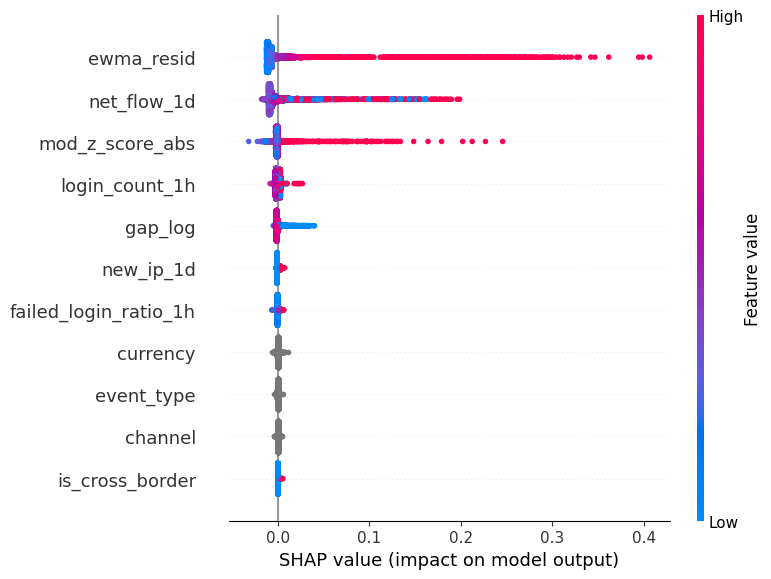

In [32]:
pred_surrogate = surrogate.predict(train_h2o).as_data_frame().values.flatten()
true_score = train_df["final_score"].values

from sklearn.metrics import r2_score

print("Surrogate R2:", r2_score(true_score, pred_surrogate))

# Feature matrix (must match training features order)
X = train_df[model_features]

# Plot
shap.summary_plot(shap_df.values, X)


In [35]:
RISK_MAPPING = {

    # Monetary Behavior
    "mod_z_score_abs": {
        "category": "Monetary Deviation",
        "template": "Transaction amount deviates from user's historical behavior."
    },
    "ewma_resid": {
        "category": "Monetary Deviation",
        "template": "Transaction differs from recent spending trend."
    },
    "net_flow_1d": {
        "category": "Liquidity Shift",
        "template": "Unusual daily net cash flow movement detected."
    },

    # Temporal Behavior
    "gap_log": {
        "category": "Temporal Anomaly",
        "template": "Transaction timing gap is inconsistent with prior activity."
    },

    # Access Risk
    "login_count_1h": {
        "category": "Access Risk",
        "template": "Abnormal login frequency observed."
    },
    "failed_login_ratio_1h": {
        "category": "Access Risk",
        "template": "Elevated failed login attempts detected."
    },
    "new_ip_1d": {
        "category": "Access Risk",
        "template": "Transaction initiated from a new IP address."
    },

    # Geographic Risk
    "is_cross_border": {
        "category": "Geolocation Risk",
        "template": "Transaction occurred outside user's residence country."
    }
}


In [36]:
def generate_human_explanation(feature, value, shap_value):

    direction = "increased" if shap_value > 0 else "reduced"

    def safe_float(v):
        try:
            return float(v)
        except:
            return None

    value = safe_float(value)

    explanations = {
        "mod_z_score_abs": (
            f"Transaction amount deviates significantly from user's normal behavior "
            f"(Z-score={value:.2f}). This {direction} anomaly risk."
            if value is not None else
            f"Transaction amount deviates significantly from user's normal behavior. "
            f"This {direction} anomaly risk."
        ),

        "ewma_resid": (
            f"Recent transaction amount differs from short-term trend "
            f"(EWMA residual={value:.2f}). This {direction} anomaly risk."
            if value is not None else
            f"Recent transaction amount differs from short-term trend. "
            f"This {direction} anomaly risk."
        ),

        "gap_log": (
            f"Transaction timing gap is unusual compared to prior activity "
            f"(gap_log={value:.2f}). This {direction} anomaly risk."
            if value is not None else
            f"Transaction timing gap is unusual compared to prior activity. "
            f"This {direction} anomaly risk."
        ),

        "net_flow_1d": (
            f"Daily net cash flow shift detected "
            f"(net_flow_1d={value:.2f}). This {direction} anomaly risk."
            if value is not None else
            f"Daily net cash flow shift detected. "
            f"This {direction} anomaly risk."
        ),

        "login_count_1h": (
            f"Abnormal login frequency in past hour "
            f"(count={int(value)}). This {direction} anomaly risk."
            if value is not None else
            f"Abnormal login frequency in past hour. "
            f"This {direction} anomaly risk."
        ),

        "failed_login_ratio_1h": (
            f"Elevated failed login attempts ratio "
            f"({value:.2f}). This {direction} anomaly risk."
            if value is not None else
            f"Elevated failed login attempts detected. "
            f"This {direction} anomaly risk."
        ),

        "new_ip_1d":
            f"New IP address detected in last 24h. "
            f"This {direction} anomaly risk.",

        "is_cross_border":
            f"Transaction occurred outside user's residence country. "
            f"This {direction} anomaly risk."
    }

    return explanations.get(
        feature,
        f"{feature} contributed to anomaly score and {direction} risk."
    )


In [49]:
def classify_severity(score):
    if score < 0.30:
        return "LOW"
    elif score < 0.70:
        return "MEDIUM"
    else:
        return "HIGH"

In [37]:
def compute_shap_batch(df_input):

    if isinstance(df_input, dict):
        df_input = pd.DataFrame([df_input])

    h2o_frame = h2o.H2OFrame(df_input)

    for col in cat_features:
        if col in df_input.columns:
            h2o_frame[col] = h2o_frame[col].asfactor()

    shap_val = surrogate.predict_contributions(h2o_frame)
    shap_df = shap_val.as_data_frame().drop(columns=["BiasTerm"])

    return shap_df


In [38]:
def convert_to_risk_evidence(feature, shap_value, raw_value):

    if feature not in RISK_MAPPING:
        return None

    risk_info = RISK_MAPPING[feature]
    direction = "increased" if shap_value > 0 else "reduced"

    explanation_text = generate_human_explanation(
        feature, raw_value, shap_value
    )

    return {
        "risk_category": risk_info["category"],
        "feature": feature,
        "impact": direction,
        "contribution": float(shap_value),
        "explanation": explanation_text
    }


In [102]:
# def build_readable_explanations(df_input, shap_df, top_n=2, min_abs_contribution=1e-4):

#     outputs = []

#     for idx in range(len(df_input)):

#         shap_series = shap_df.iloc[idx]
#         shap_series = shap_series[shap_series.abs() > min_abs_contribution]

#         shap_series = shap_series.reindex(
#             shap_series.abs().sort_values(ascending=False).index
#         )

#         top_features = shap_series.head(top_n)

#         explanations = []

#         for feature, shap_value in top_features.items():

#             raw_value = (
#                 df_input.iloc[idx][feature]
#                 if feature in df_input.columns else None
#             )

#             evidence = convert_to_risk_evidence(
#                 feature, shap_value, raw_value
#             )

#             if evidence:
#                 explanations.append(evidence)

#         outputs.append(explanations)

#     return outputs


In [103]:
# def aggregate_by_category(evidence_list):

#     category_summary = {}

#     for item in evidence_list:

#         category = item["risk_category"]
#         contribution = item["contribution"]

#         if category not in category_summary:
#             category_summary[category] = {
#                 "total_contribution": 0.0,
#                 "net_direction_score": 0.0
#             }

#         category_summary[category]["total_contribution"] += abs(contribution)
#         category_summary[category]["net_direction_score"] += contribution

#     output = []

#     for category, values in category_summary.items():

#         direction = (
#             "increased"
#             if values["net_direction_score"] > 0
#             else "reduced"
#         )

#         output.append({
#             "risk_category": category,
#             "impact": direction,
#             "strength": round(values["total_contribution"], 6)
#         })

#     output = sorted(output, key=lambda x: x["strength"], reverse=True)

#     return output


In [104]:
def build_behavior_output(df_input, top_n=2, min_abs_contribution=1e-4):

    if isinstance(df_input, dict):
        df_input = pd.DataFrame([df_input])

    shap_df = compute_shap_batch(df_input)

    results = []

    for idx in range(len(df_input)):

        row = df_input.iloc[idx]
        shap_series = shap_df.iloc[idx]

        # Remove tiny noise
        shap_series = shap_series[shap_series.abs() > min_abs_contribution]

        # Sort by absolute contribution
        shap_series = shap_series.reindex(
            shap_series.abs().sort_values(ascending=False).index
        )

        # Top drivers
        top_features = shap_series.head(top_n)

        evidence_list = []

        for feature, shap_value in top_features.items():

            raw_value = row.get(feature, None)

            evidence = convert_to_risk_evidence(
                feature, shap_value, raw_value
            )

            if evidence:
                evidence_list.append(evidence)

        # -------- Highest impact signal --------
        if evidence_list:
            highest_signal = evidence_list[0]["risk_category"]
        else:
            highest_signal = "No significant anomaly drivers detected."

        # -------- Severity --------
        anomaly_level = float(row["final_score"]/threshold)
        severity = classify_severity(anomaly_level)

        # -------- Output --------

        result = {
            "event_time": str(row["event_time"]),
            "txn_id": str(row["txn_id"]),
            "user_id": str(row["user_id"]),
            "is_anomaly": int(row["is_anomaly"]),
            "detector_type": "BEHAVIOR",
            "signal": highest_signal,
            "severity": severity,
            "confidence": str(row["confidence_score"]),
            "evidence": evidence_list
        }

        results.append(result)

    if len(results) == 1:
        return results[0]

    return results

In [68]:
# test_df.loc[test_df['user_id'] == 'u_090']
test_df.loc[test_df['user_id'] == 'u_090'][0:1]["is_anomaly"]

4467    1
Name: is_anomaly, dtype: int64

In [105]:
# # build_behavior_output((test_df.loc[test_df['user_id'] == 'u_090'])[0:1])
build_behavior_output(test_df[9:10])
# build_behavior_output((test_df.head(10)))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
contributions progress: |████████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'event_time': '2025-11-14 06:09:34',
 'txn_id': 'tx9491',
 'user_id': 'u_001',
 'is_anomaly': 0,
 'detector_type': 'BEHAVIOR',
 'signal': 'Monetary Deviation',
 'severity': 'LOW',
 'confidence': '0.9925058745445317',
 'evidence': [{'risk_category': 'Monetary Deviation',
   'feature': 'ewma_resid',
   'impact': 'reduced',
   'contribution': -0.01170374173671,
   'explanation': 'Recent transaction amount differs from short-term trend (EWMA residual=505.82). This reduced anomaly risk.'},
  {'risk_category': 'Liquidity Shift',
   'feature': 'net_flow_1d',
   'impact': 'reduced',
   'contribution': -0.0090459659695625,
   'explanation': 'Daily net cash flow shift detected (net_flow_1d=1561.97). This reduced anomaly risk.'}]}

In [64]:
user_anom = (
    test_df.groupby("user_id")["is_anomaly"]
    .sum()
    .sort_values(ascending=False)
)

print("Top 10 users by anomaly count:")
print(user_anom.head(10))


Top 10 users by anomaly count:
user_id
u_090    11
u_186    10
u_029     9
u_182     9
u_157     8
u_385     6
u_192     6
u_313     6
u_014     6
u_000     6
Name: is_anomaly, dtype: int64


In [65]:
n_users = user_anom.shape[0]
top_k = max(1, int(0.05 * n_users))

share_top5 = user_anom.head(top_k).sum() / (user_anom.sum() + 1e-9)

print(f"Top 5% users contribute: {share_top5:.2%} of all anomalies")


Top 5% users contribute: 59.50% of all anomalies


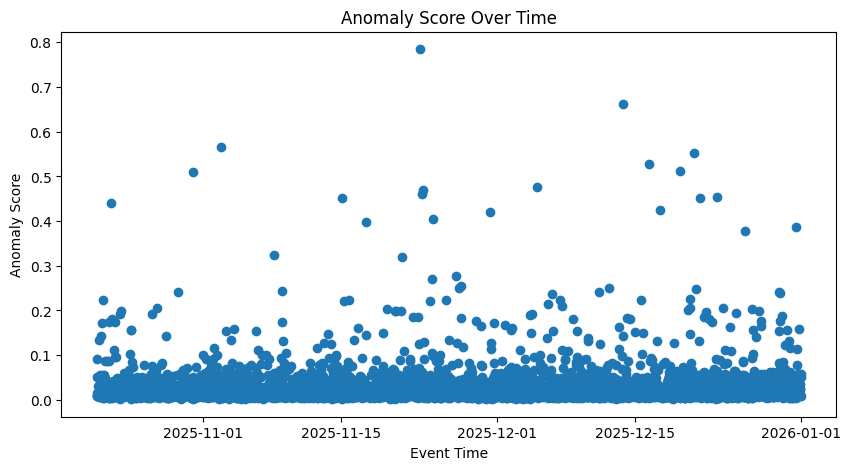

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(
    test_df["event_time"],
    test_df["final_score"]
)
plt.xlabel("Event Time")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Score Over Time")
plt.show()


In [138]:
import os
import json

class BehaviorInferenceEngine:
  RISK_MAPPING = {

    # Monetary Behavior
    "mod_z_score_abs": {
        "category": "Monetary Deviation",
        "template": "Transaction amount deviates from user's historical behavior."
    },
    "ewma_resid": {
        "category": "Monetary Deviation",
        "template": "Transaction differs from recent spending trend."
    },
    "net_flow_1d": {
        "category": "Liquidity Shift",
        "template": "Unusual daily net cash flow movement detected."
    },

    # Temporal Behavior
    "gap_log": {
        "category": "Temporal Anomaly",
        "template": "Transaction timing gap is inconsistent with prior activity."
    },

    # Access Risk
    "login_count_1h": {
        "category": "Access Risk",
        "template": "Abnormal login frequency observed."
    },
    "failed_login_ratio_1h": {
        "category": "Access Risk",
        "template": "Elevated failed login attempts detected."
    },
    "new_ip_1d": {
        "category": "Access Risk",
        "template": "Transaction initiated from a new IP address."
    },

    # Geographic Risk
    "is_cross_border": {
        "category": "Geolocation Risk",
        "template": "Transaction occurred outside user's residence country."
    }
}

  def __init__(self, model_dir="behavior_assets"):
    self.model_dir = model_dir
    self.cat_features = ["currency", "channel", "event_type", "geo_country"]
    self.num_features = ["mod_z_score_abs", "ewma_resid", "gap_log", "net_flow_1d", "login_count_1h", "failed_login_ratio_1h", "new_ip_1d", "is_cross_border"]
    self.lstm_features = ["amount_abs", "gap_log", "amount_to_income_ratio", "net_flow_1d", "deposit_to_income_ratio", "mod_z_score_abs", "ewma_resid"]

  # HELPER FUNCTIONS FOR SHAP
  def _classify_severity(self, score, is_anomaly):
      if score < 0.30 or not is_anomaly:
          return "LOW"
      elif score < 0.70:
          return "MEDIUM"
      else:
          return "HIGH"

  def _apply_confidence(self, df, threshold, std):
      k = 3.0 / (std + 1e-9) # Using 3.0 makes the curve slightly smoother

      # Calculate distance from threshold
      # If positive, it's an anomaly; if negative, it's normal
      diff = df["final_score"] - threshold

      # Apply Sigmoid
      # This maps scores:
      # Much higher than threshold -> ~1.0
      # Exactly threshold -> 0.5
      # Much lower than threshold -> ~0.0 (meaning 100% confident it is NORMAL)
      conf = 1 / (1 + np.exp(-k * diff))

      # Confidence in the decision (0.5 to 1)
      return np.where(conf >= 0.5, conf, 1 - conf)

  def _generate_human_explanation(self, feature, value, shap_value):

      direction = "increased" if shap_value > 0 else "reduced"

      def safe_float(v):
          try:
              return float(v)
          except:
              return None

      value = safe_float(value)

      explanations = {
          "mod_z_score_abs": (
              f"Transaction amount deviates significantly from user's normal behavior "
              f"(Z-score={value:.2f}). This {direction} anomaly risk."
              if value is not None else
              f"Transaction amount deviates significantly from user's normal behavior. "
              f"This {direction} anomaly risk."
          ),

          "ewma_resid": (
              f"Recent transaction amount differs from short-term trend "
              f"(EWMA residual={value:.2f}). This {direction} anomaly risk."
              if value is not None else
              f"Recent transaction amount differs from short-term trend. "
              f"This {direction} anomaly risk."
          ),

          "gap_log": (
              f"Transaction timing gap is unusual compared to prior activity "
              f"(gap_log={value:.2f}). This {direction} anomaly risk."
              if value is not None else
              f"Transaction timing gap is unusual compared to prior activity. "
              f"This {direction} anomaly risk."
          ),

          "net_flow_1d": (
              f"Daily net cash flow shift detected "
              f"(net_flow_1d={value:.2f}). This {direction} anomaly risk."
              if value is not None else
              f"Daily net cash flow shift detected. "
              f"This {direction} anomaly risk."
          ),

          "login_count_1h": (
              f"Abnormal login frequency in past hour "
              f"(count={int(value)}). This {direction} anomaly risk."
              if value is not None else
              f"Abnormal login frequency in past hour. "
              f"This {direction} anomaly risk."
          ),

          "failed_login_ratio_1h": (
              f"Elevated failed login attempts ratio "
              f"({value:.2f}). This {direction} anomaly risk."
              if value is not None else
              f"Elevated failed login attempts detected. "
              f"This {direction} anomaly risk."
          ),

          "new_ip_1d":
              f"New IP address detected in last 24h. "
              f"This {direction} anomaly risk.",

          "is_cross_border":
              f"Transaction occurred outside user's residence country. "
              f"This {direction} anomaly risk."
      }

      return explanations.get(
          feature,
          f"{feature} contributed to anomaly score and {direction} risk."
      )

  def _compute_shap_batch(self, df_input):

      if isinstance(df_input, dict):
          df_input = pd.DataFrame([df_input])

      h2o_frame = h2o.H2OFrame(df_input)

      for col in self.cat_features:
          if col in df_input.columns:
              h2o_frame[col] = h2o_frame[col].asfactor()

      shap_val = self.surrogate.predict_contributions(h2o_frame)
      shap_df = shap_val.as_data_frame().drop(columns=["BiasTerm"])

      return shap_df

  def _convert_to_risk_evidence(self, feature, shap_value, raw_value):

      if feature not in self.RISK_MAPPING:
          return None

      risk_info = self.RISK_MAPPING[feature]
      direction = "increased" if shap_value > 0 else "reduced"

      explanation_text = self._generate_human_explanation(
          feature, raw_value, shap_value
      )

      return {
          "risk_category": risk_info["category"],
          "feature": feature,
          "impact": direction,
          "contribution": float(shap_value),
          "explanation": explanation_text
      }


  def _build_behavior_output(self, df_input, top_n=2, min_abs_contribution=1e-4):

      if isinstance(df_input, dict):
          df_input = pd.DataFrame([df_input])

      shap_df = self._compute_shap_batch(df_input)

      results = []

      for idx in range(len(df_input)):

          row = df_input.iloc[idx]
          shap_series = shap_df.iloc[idx]

          # Remove tiny noise
          shap_series = shap_series[shap_series.abs() > min_abs_contribution]

          # Sort by absolute contribution
          shap_series = shap_series.reindex(
              shap_series.abs().sort_values(ascending=False).index
          )

          # Top drivers
          top_features = shap_series.head(top_n)

          evidence_list = []

          for feature, shap_value in top_features.items():

              raw_value = row.get(feature, None)

              evidence = self._convert_to_risk_evidence(
                  feature, shap_value, raw_value
              )

              if evidence:
                  evidence_list.append(evidence)

          # -------- Highest impact signal --------
          if evidence_list:
              highest_signal = evidence_list[0]["risk_category"]
          else:
              highest_signal = "No significant anomaly drivers detected."

          # -------- Severity --------
          anomaly_level = float(row["final_score"]/self.threshold)
          severity = self._classify_severity(anomaly_level,row["is_anomaly"])

          # -------- Output --------

          result = {
              "event_time": str(row["event_time"]),
              "txn_id": str(row["txn_id"]),
              "user_id": str(row["user_id"]),
              "is_anomaly": int(row["is_anomaly"]),
              "detector_type": "BEHAVIOR",
              "signal": highest_signal,
              "severity": severity,
              "confidence": str(row["confidence_score"]),
              "evidence": evidence_list
          }

          results.append(result)

      if len(results) == 1:
          return results[0]

      return results

  def save_assets(self, eif, surrogate, lstm, seq_scaler, feature_scaler, cohort_stats, global_stats, threshold, weights, scores_std):
    if not os.path.exists(self.model_dir): os.makedirs(self.model_dir)
    h2o.save_model(model=eif, path=self.model_dir, force=True)
    h2o.save_model(model=surrogate, path=self.model_dir, force=True)
    lstm.save(f"{self.model_dir}/lstm_model.h5")
    joblib.dump(seq_scaler, f"{self.model_dir}/seq_scaler.pkl")
    joblib.dump(feature_scaler, f"{self.model_dir}/feature_scaler.pkl")
    joblib.dump(cohort_stats, f"{self.model_dir}/cohort_stats.pkl")
    joblib.dump(global_stats, f"{self.model_dir}/global_stats.pkl")
    joblib.dump({"threshold": threshold, "weights": weights, "eif_id": eif.model_id, "surr_id": surrogate.model_id, "scores_std": scores_std}, f"{self.model_dir}/meta.pkl")

  def load_assets(self):
    h2o.init()
    meta = joblib.load(f"{self.model_dir}/meta.pkl")
    self.threshold = meta['threshold']
    self.weights = meta['weights']
    self.scores_std = meta['scores_std']
    self.eif = h2o.load_model(f"{self.model_dir}/{meta['eif_id']}")
    self.surrogate = h2o.load_model(f"{self.model_dir}/{meta['surr_id']}")
    self.lstm = tf.keras.models.load_model(f"{self.model_dir}/lstm_model.h5", custom_objects={"mse": tf.keras.losses.MeanSquaredError()})
    self.seq_scaler = joblib.load(f"{self.model_dir}/seq_scaler.pkl")
    self.feature_scaler = joblib.load(f"{self.model_dir}/feature_scaler.pkl")
    self.cohort_stats = joblib.load(f"{self.model_dir}/cohort_stats.pkl")
    self.global_stats = joblib.load(f"{self.model_dir}/global_stats.pkl")

  def _engineer(self, df):
    df = df.copy()
    df["event_time"] = pd.to_datetime(df["event_time"])
    df = df.sort_values("event_time")
    for c in ["currency", "channel", "residence_country", "geo_country", "event_type"]:
        if c in df.columns: df[c] = df[c].astype(str).str.strip().str.lower()

    # Financial ratios calculation
    df["amount_abs"] = df["amount"].abs()
    df["amount_to_income_ratio"] = df["amount_abs"] / (df["declared_income"] + 1e-9)
    df["deposit_to_income_ratio"] = df["account_deposit"] / (df["declared_income"] + 1e-9)
    df["net_flow_1d"] = df["amount_in_1d"] - df["amount_out_1d"]

    # Location
    df["is_cross_border"] = (df["residence_country"] != df["geo_country"]).astype(int)
    df["failed_login_ratio_1h"] = df["failed_login_1h"] / (df["login_count_1h"] + 1e-9)
    df["new_ip_1d"] = df["new_ip_1d"].fillna(0)
    df["geo_change_1d"] = df["geo_change_1d"].fillna(0)

    # Transaction gap
    df["gap_seconds"] = df["event_time"].diff().dt.total_seconds().fillna(self.global_stats['median_gap'])
    df["gap_log"] = np.log1p(df["gap_seconds"])

    # Window period
    df["user_median_15"] = df["amount_abs"].rolling(window=15, min_periods=1).median()
    df["user_mad_15"] = df["amount_abs"].rolling(window=15, min_periods=1).apply(lambda x: median_abs_deviation(x, scale='normal') if len(x)>1 else self.global_stats['mad'], raw=False)

    for col in ["cohort_median", "cohort_mad"]:
      if col in df.columns:
          df = df.drop(columns=col)

    df = df.merge(self.cohort_stats, on=["currency", "geo_country", "channel", "event_type"], how="left")
    b_med = df["user_median_15"].fillna(df["cohort_median"]).fillna(self.global_stats['median_amt'])
    b_mad = df["user_mad_15"].fillna(df["cohort_mad"]).fillna(self.global_stats['mad'])
    df["mod_z_score_abs"] = (0.6745 * (df["amount_abs"] - b_med) / (b_mad + 1e-9)).abs()
    df["ewma_resid"] = (df["amount_abs"] - df["amount_abs"].ewm(span=8).mean()).abs()
    return df

  def predict(self, raw_json):
    # 1. Parse & Engineer
    input_df = pd.DataFrame(json.loads(raw_json))
    feat_df = self._engineer(input_df)

    # 2. Points Score (EIF)
    h2o_fr = h2o.H2OFrame(feat_df[self.cat_features + self.num_features])
    for c in self.cat_features: h2o_fr[c] = h2o_fr[c].asfactor()
    feat_df["iforest_score"] = self.eif.predict(h2o_fr)["anomaly_score"].as_data_frame().iloc[:, 0].values

    # 3. Sequence Score (LSTM)
    scaled_lstm = self.seq_scaler.transform(feat_df[self.lstm_features].fillna(0))
    if len(scaled_lstm) >= 20:
        seq = np.array([scaled_lstm[-20:]])
        feat_df.loc[feat_df.index[-1], "lstm_score"] = np.mean((seq - self.lstm.predict(seq, verbose=0))**2)
    else:
        feat_df["lstm_score"] = self.global_stats['lstm_median']

    # 4. Ensemble
    detector_cols = ["mod_z_score_abs", "ewma_resid", "iforest_score", "lstm_score"]
    n_vals = self.feature_scaler.transform(feat_df[detector_cols].fillna(0))
    feat_df["final_score"] = np.sum([self.weights[c] * n_vals[:, i] for i, c in enumerate(detector_cols)], axis=0)
    feat_df["is_anomaly"] = (feat_df["final_score"] >= self.threshold).astype(int)
    feat_df["confidence_score"] = self._apply_confidence(feat_df, self.threshold, self.scores_std)

    # 5. SHAP & Formatting
    shap_vals = self.surrogate.predict_contributions(h2o_fr).as_data_frame().drop(columns=["BiasTerm"])

    # Take the last transaction results
    final_prediction = self._build_behavior_output(feat_df)

    return final_prediction


In [132]:
# Prepare the fallback stats for the package
global_stats = {
    'median_gap': df['gap_seconds'].median(),
    'median_amt': df['amount_abs'].median(),
    'mad': median_abs_deviation(df['amount_abs'], scale='normal'),
    'lstm_median': test_df['lstm_score'].median()
}

# Save using the engine
engine = BehaviorInferenceEngine()
engine.save_assets(
    eif=eif, surrogate=surrogate, lstm=lstm_model,
    seq_scaler=seq_scaler, feature_scaler=scaler,
    cohort_stats=cohort_stats, global_stats=global_stats,
    threshold=threshold, weights=weights, scores_std=test_scores_std
)

In [120]:
print(cohort_stats.columns)

Index(['currency', 'geo_country', 'channel', 'event_type', 'cohort_median',
       'cohort_mad'],
      dtype='str')


In [137]:
# 1. Load the model (Imagine this is a fresh server)
prod_engine = BehaviorInferenceEngine()
prod_engine.load_assets()

# 2. Input JSON
test_data_path = "test_transactions 2.csv"
df_test = pd.read_csv(test_data_path)

raw_input = df_test[df_test['user_id'] == 'U1001'].to_json(orient='records')
print(raw_input)

# 3. Predict!
result_json = prod_engine.predict(raw_input)
print(json.dumps(result_json, indent=2))

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 hours 20 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,2 months and 19 days
H2O_cluster_name:,H2O_from_python_unknownUser_w3pakh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.005 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


[{"user_id":"U1001","txn_id":1,"event_time":"2026-03-01T09:00:00","event_type":"deposit","amount":500,"currency":"usd","channel":"mobile","declared_income":5000,"account_deposit":3000,"residence_country":"us","geo_country":"us","amount_in_1d":500,"amount_out_1d":0,"login_count_1h":3,"failed_login_1h":0,"new_ip_1d":false,"geo_change_1d":false},{"user_id":"U1001","txn_id":2,"event_time":"2026-03-01T12:00:00","event_type":"buy","amount":200,"currency":"usd","channel":"mobile","declared_income":5000,"account_deposit":2800,"residence_country":"us","geo_country":"us","amount_in_1d":700,"amount_out_1d":0,"login_count_1h":2,"failed_login_1h":0,"new_ip_1d":false,"geo_change_1d":false},{"user_id":"U1001","txn_id":3,"event_time":"2026-03-01T18:00:00","event_type":"withdrawal","amount":300,"currency":"usd","channel":"mobile","declared_income":5000,"account_deposit":2500,"residence_country":"us","geo_country":"us","amount_in_1d":700,"amount_out_1d":300,"login_count_1h":2,"failed_login_1h":0,"new_ip

/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


████████████████████████████████████████████████████████| (done) 100%
Parse progress: |

/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


████████████████████████████████████████████████████████████████| (done) 100%
contributions progress: |████████████████████████████████████████████████████████| (done) 100%
[
  {
    "event_time": "2026-03-01 09:00:00",
    "txn_id": "1",
    "user_id": "U1001",
    "is_anomaly": 0,
    "detector_type": "BEHAVIOR",
    "signal": "Liquidity Shift",
    "severity": "LOW",
    "confidence": "0.9939026409883166",
    "evidence": [
      {
        "risk_category": "Liquidity Shift",
        "feature": "net_flow_1d",
        "impact": "reduced",
        "contribution": -0.0096564134582877,
        "explanation": "Daily net cash flow shift detected (net_flow_1d=500.00). This reduced anomaly risk."
      },
      {
        "risk_category": "Monetary Deviation",
        "feature": "ewma_resid",
        "impact": "reduced",
        "contribution": -0.0090642059221863,
        "explanation": "Recent transaction amount differs from short-term trend (EWMA residual=0.00). This reduced anomaly risk."

/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
